---
# Spark Exploration Exercises
---

In [1]:
import pyspark
from pyspark.sql.functions import *
import wrangle
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.ion()
# tweak the matplotlib style defaults
plt.rc("figure", figsize=(13, 7))
plt.rc("font", size=14)
plt.style.use("ggplot")

In [2]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle.wrangle_311(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


In [3]:
df.show(1, vertical=True, truncate=False)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207                                
 case_ag

---
## 1.

How many different cases are there, by department?

In [4]:
def format_number(x, *args):
    return "{:.0f}k".format(x / 1000)

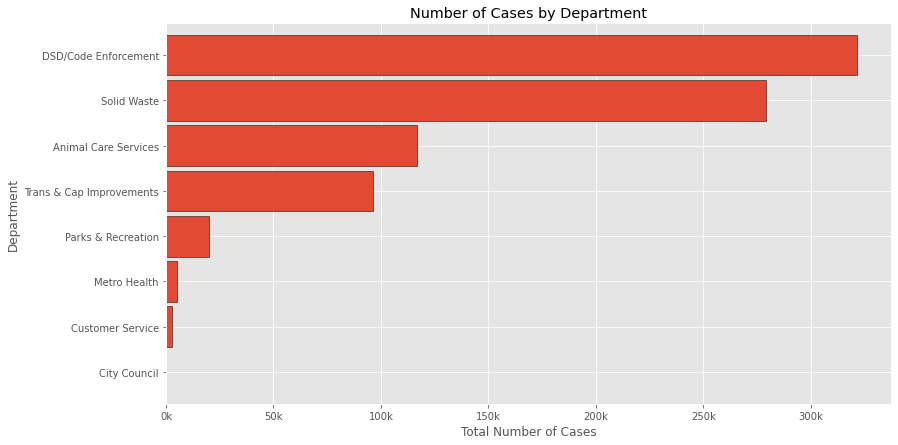

In [5]:
(
    df.groupBy('department')
    .count()
    .toPandas()
    .set_index('department')['count']
    .sort_values()
    .plot.barh(ec='black', width=0.9)
)
plt.gca().set(ylabel='Department', xlabel='Total Number of Cases', title='Number of Cases by Department')
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_number));

---
## 2.

Does the percentage of cases that are late vary by department?

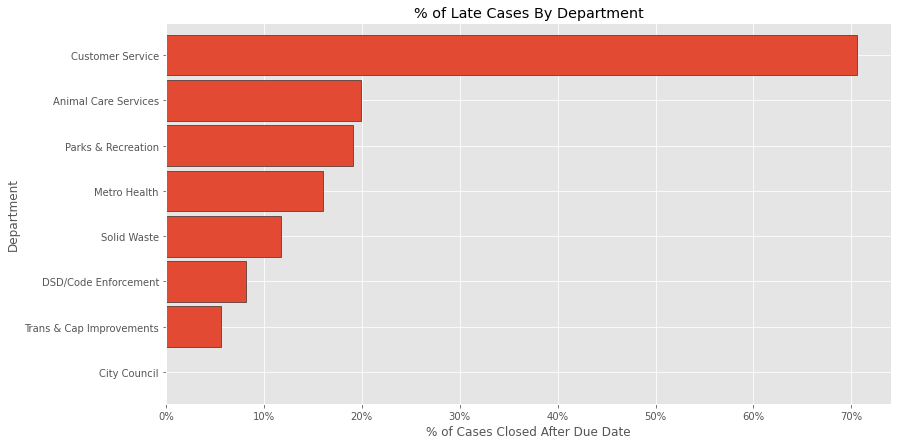

In [6]:
(
    df.withColumn('case_late', col('case_late').cast('int'))
    .groupBy('department')
    .agg(avg('case_late').alias('p_cases_late'))
    .toPandas()
    .set_index('department')
    .p_cases_late.sort_values()
    .plot.barh(ec='black', width=0.9)
)
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter("{:.0%}".format))
plt.gca().set(
    ylabel="Department",
    xlabel="% of Cases Closed After Due Date",
    title="% of Late Cases By Department",
);

---
## 3.

On average, how late are the late cases by department?

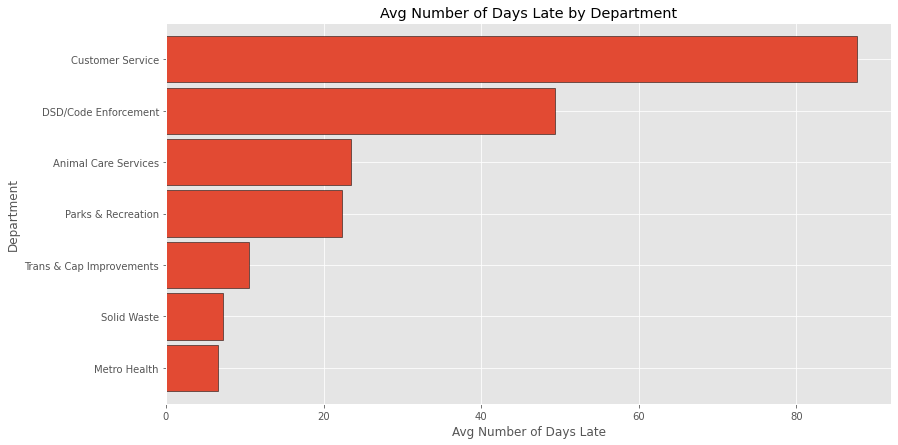

In [7]:
(
    df.filter('case_late') # filter to get only late cases
    .groupBy('department')
    .agg(avg('num_days_late').alias('avg_days_late'))
    .toPandas()
    .set_index('department')
    .avg_days_late.sort_values()
    .plot.barh(ec='black', width=0.9)
)
plt.gca().set(ylabel='Department', xlabel='Avg Number of Days Late', title='Avg Number of Days Late by Department');

---
## 4.

What is the service type that is the most late? Just for Parks & Rec?

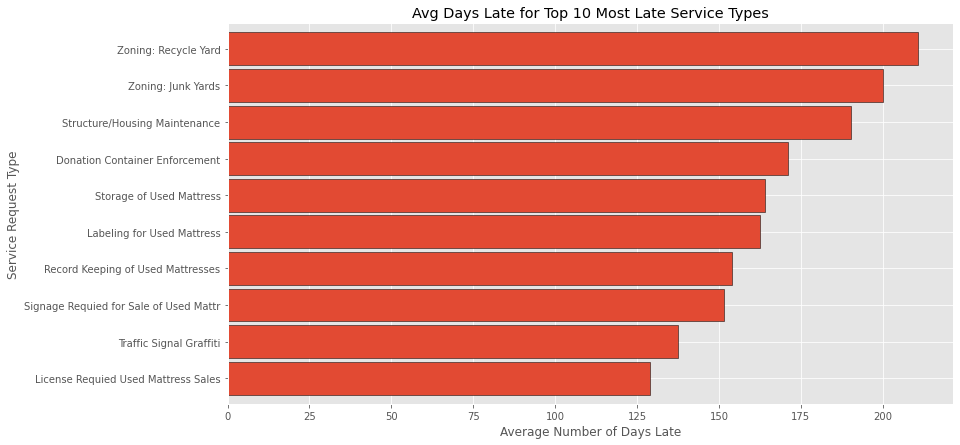

In [8]:
(
    df.filter('case_late')
    .groupBy('service_request_type')
    .agg(avg('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .limit(10)
    .toPandas()
    .set_index('service_request_type')
    .avg_days_late.sort_values()
    .plot.barh(ec='black', width=0.9)
)
plt.gca().set(xlabel='Average Number of Days Late', ylabel='Service Request Type', title='Avg Days Late for Top 10 Most Late Service Types');

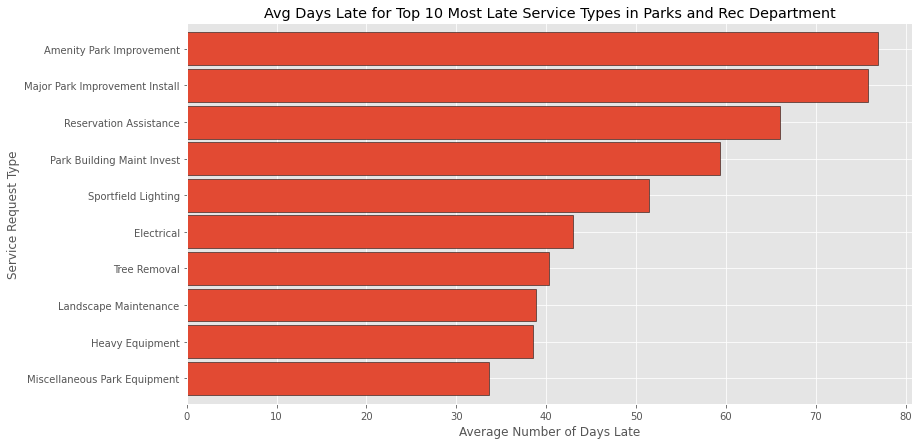

In [9]:
(
    df.filter('case_late')
    .filter(df.department == 'Parks & Recreation')
    .groupBy('service_request_type')
    .agg(avg('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .limit(10)
    .toPandas()
    .set_index('service_request_type')
    .avg_days_late.sort_values()
    .plot.barh(ec='black', width=0.9)
)
plt.gca().set(xlabel='Average Number of Days Late', ylabel='Service Request Type', title='Avg Days Late for Top 10 Most Late Service Types in Parks and Rec Department');

---
## 5.

For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

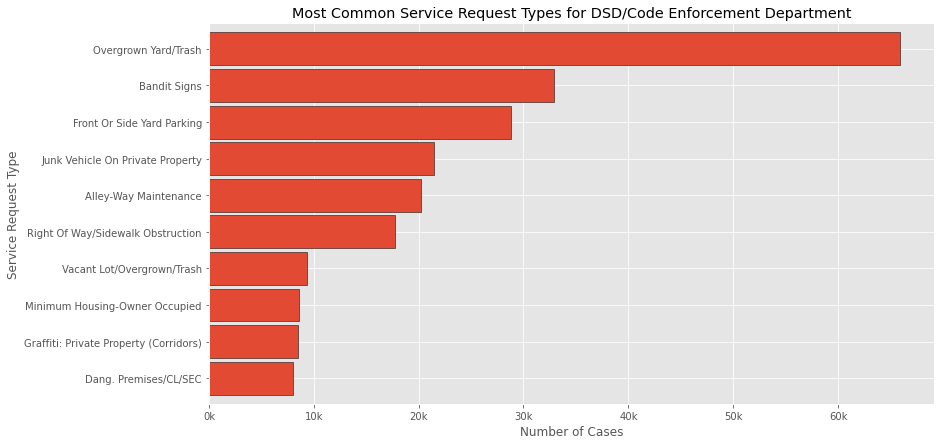

In [10]:
(
    df.filter(df.department == 'DSD/Code Enforcement')
    .groupBy('service_request_type')
    .count()
    .sort(desc('count'))
    .limit(10)
    .toPandas()
    .set_index('service_request_type')['count'].sort_values()
    .plot.barh(ec='black', width=0.9)
)
plt.gca().set(xlabel='Number of Cases', ylabel='Service Request Type', title='Most Common Service Request Types for DSD/Code Enforcement Department')

def format_number_sub_thousands(x, *args):
    return "{:.0f}k".format(x / 1000)

plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_number_sub_thousands))

In [11]:
depts = (
    df.groupBy('department')
    .count()
    .toPandas()
    .set_index('department')
)

In [12]:
depts_list = depts.index.tolist()

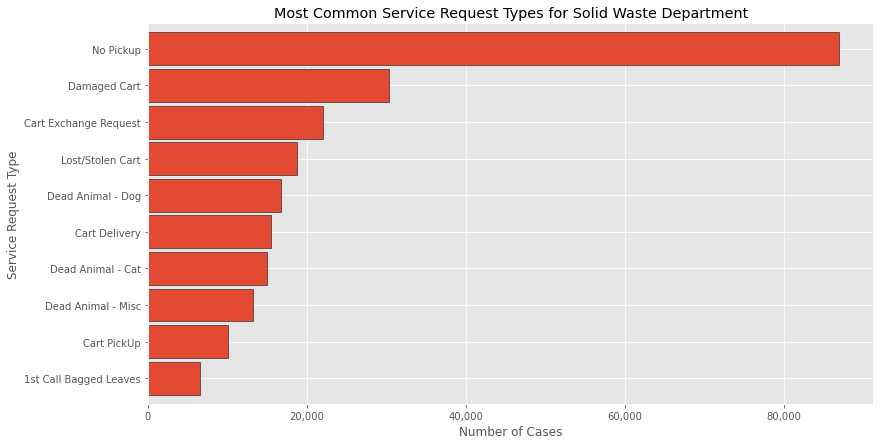

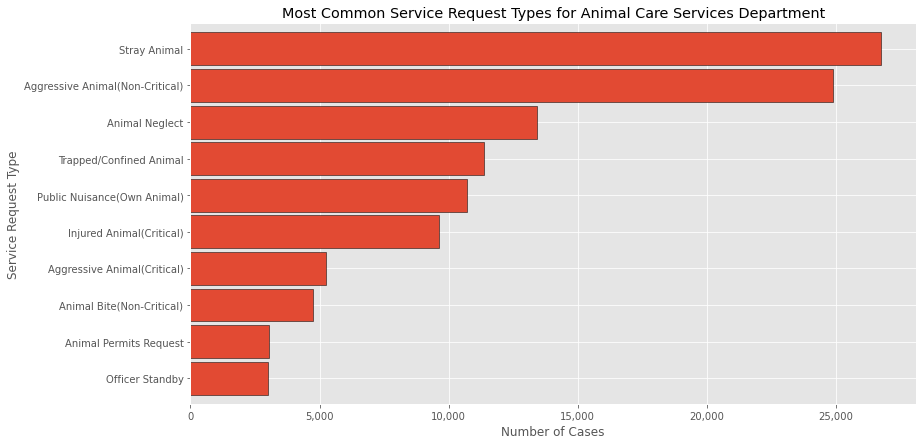

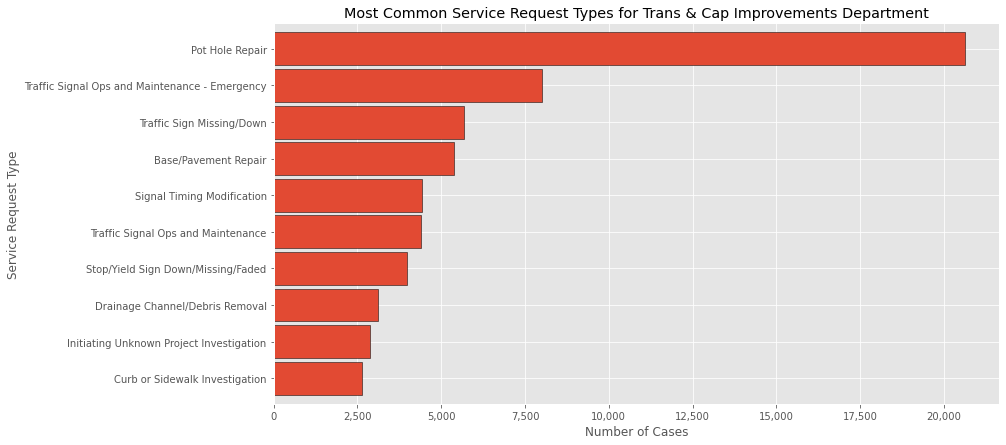

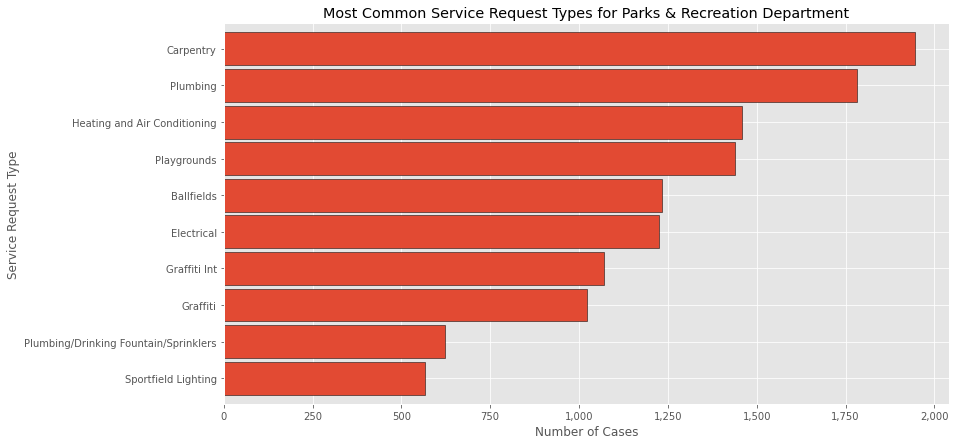

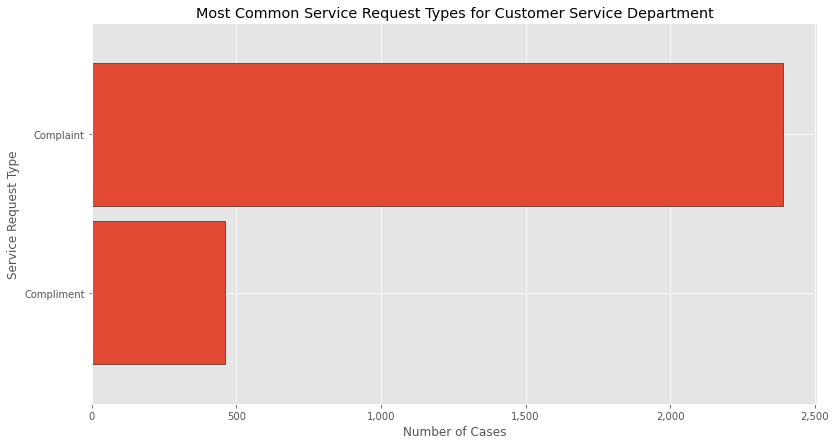

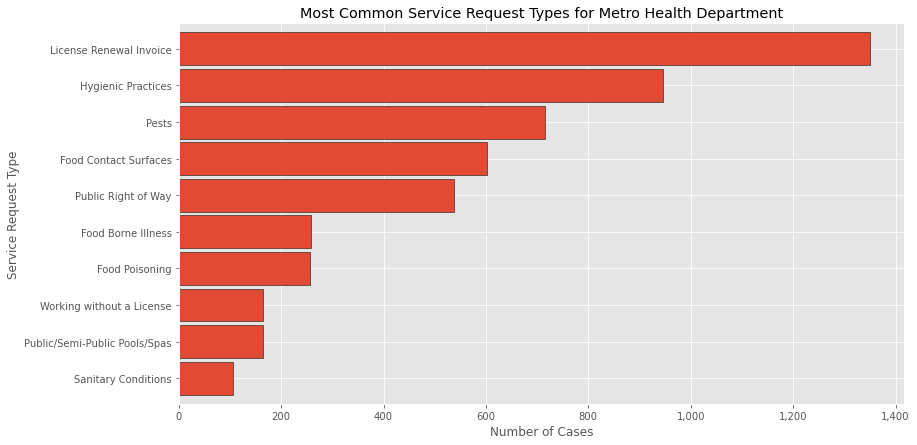

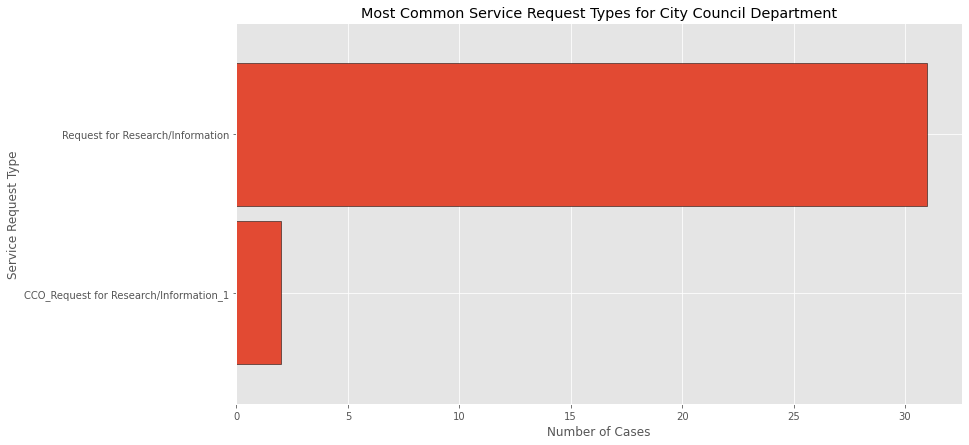

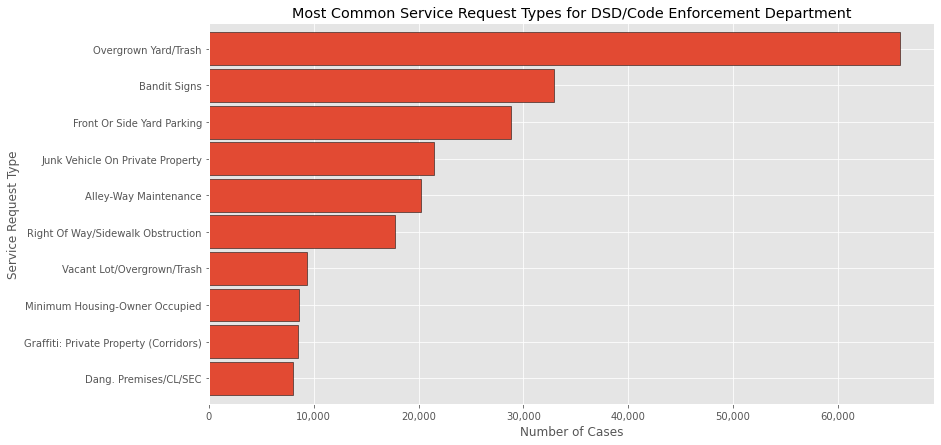

In [13]:
for dept in depts_list:
    (
    df.filter(df.department == dept)
    .groupBy('service_request_type')
    .count()
    .sort(desc('count'))
    .limit(10)
    .toPandas()
    .set_index('service_request_type')['count'].sort_values()
    .plot.barh(ec='black', width=0.9)
    )
    plt.gca().set(xlabel='Number of Cases', ylabel='Service Request Type', title=f'Most Common Service Request Types for {dept} Department')
    
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:,.0f}'.format))
    plt.show()

---
## 6.

Does whether or not its a weekend matter for when a case is opened/closed?

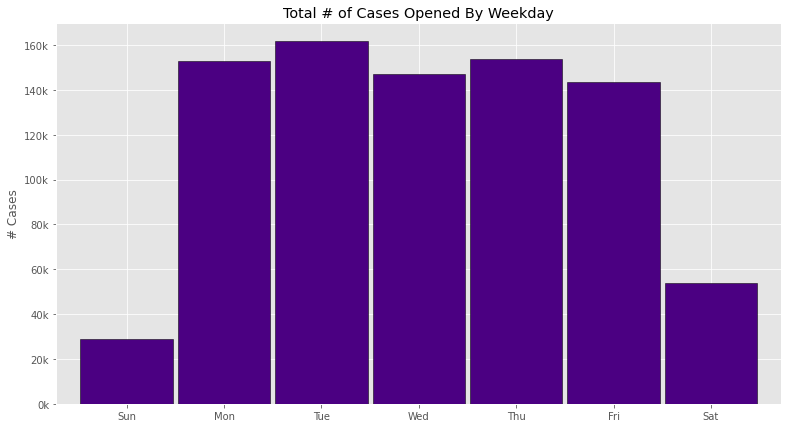

In [14]:
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

(
    df.withColumn("weekday", date_format("case_opened_date", "E"))
    # the line above is an example of doing the date formatting with spark
    # through the SimpleDateFormat api instead of with python
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    # Here we convert the weekday string to a categorical type with an order.
    # This lets us order the weekdays properly in our visualization.
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.bar(width=0.95, ec="black", color="indigo")
)

plt.xticks(rotation=0)
plt.gca().set(
    xlabel="", ylabel="# Cases", title="Total # of Cases Opened By Weekday"
)
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_number_sub_thousands))

---
## 7.

On average, how many cases are opened a day for the Customer Service department?

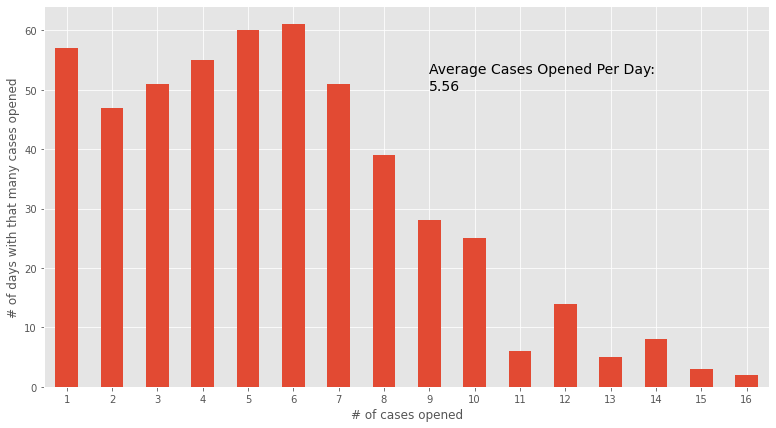

In [15]:

def plot_cases(df):
    s = df["count"]
    avg = s.mean()
    s.value_counts().sort_index().plot.bar()
    plt.text(
        8, 50, f"Average Cases Opened Per Day:\n{avg:.2f}", ha="left", size=14
    )
    plt.xlabel("# of cases opened")
    plt.ylabel("# of days with that many cases opened")
    plt.xticks(rotation=0)


(
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Customer Service")
    .groupby("case_opened_date")
    .count()
    .toPandas()
    # .pipe takes our data frame and "pipes" the dataframe into a function
    .pipe(plot_cases)
)

---
## 8.

Does the number of service requests for the solid waste department vary by day of the week?

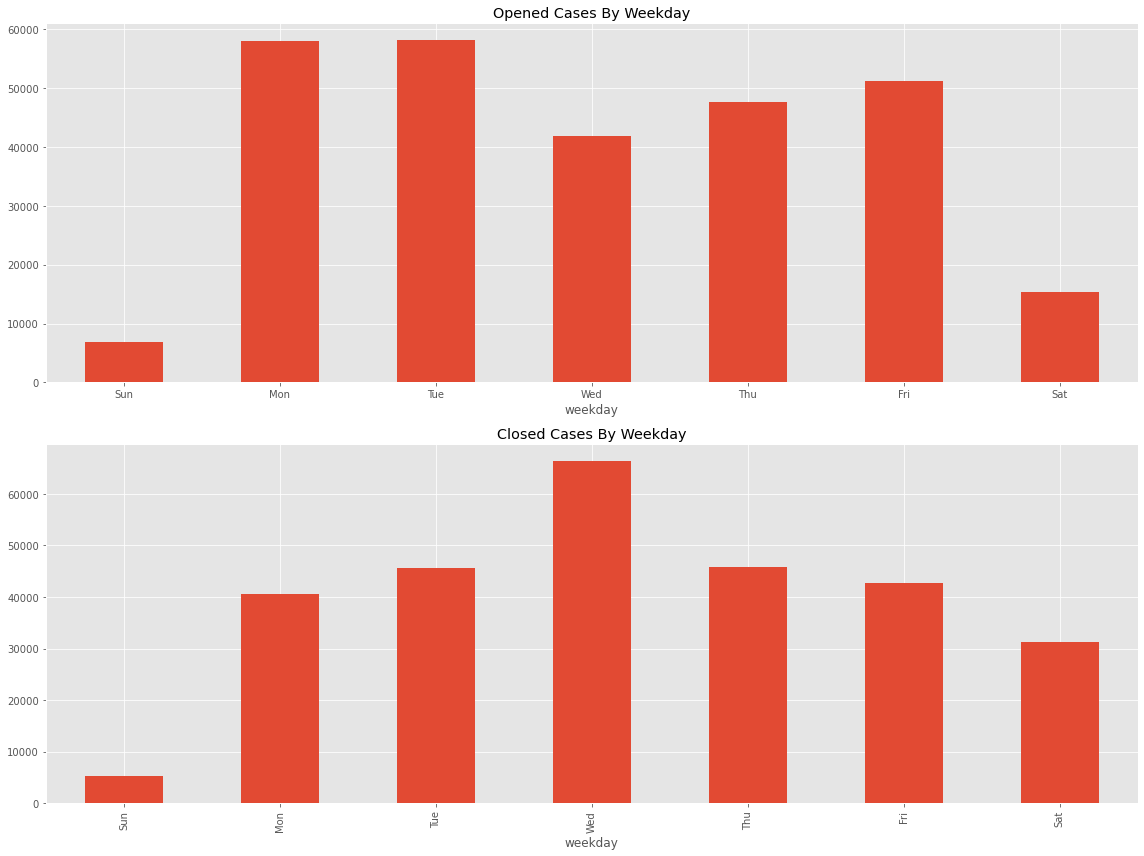

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

(
    df.withColumn("weekday", date_format("case_opened_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax1)
)
ax1.set(
    title='Opened Cases By Weekday'
)
ax1.tick_params(axis='x', labelrotation=0)


(
    df.withColumn("weekday", date_format("case_closed_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax2)
)
ax2.set(
    title='Closed Cases By Weekday'
)
fig.tight_layout()